# Interactive image processing with ipywidgets and numpy_image_widget
ipywidgets can be used in jupyter notebooks to interactively change parameters and view resuls of computation without adapting and rerunning code. The numpy image widget is a convenient addon allowing to use ipywidgets with image data as numpy arrays. Combining both allows to tune image processing workflow parameters right in your notebook.

See also: 
* [Widget types](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html)
* [Widget events](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html)
* [The Numpy Image Widget](https://github.com/Who8MyLunch/Numpy_Image_Widget)

In [1]:
!pip install pyclesperanto_prototype

Optionally exectute this to install dependencies:

!pip install ipywidgets numpy_image_widget 



In [2]:
!pip install ipywidgets numpy_image_widget 


In [3]:
import ipywidgets as widgets
import pyclesperanto_prototype as cle
import PIL
import numpy as np
import numpy_image_widget as niw
from skimage.io import imread, imshow

cle.get_device()

<Tesla T4 on Platform: NVIDIA CUDA (1 refs)>

## A simple viewer updated later on
We start with a simple NumpyImage viewer that can be updated further down in the notebook.

In [4]:
blobs = imread('https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/data/blobs.tif?raw=true')

In [5]:
blobs_view = niw.NumpyImage(blobs)
blobs_view

NumpyImage(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x05\x…

In [6]:
blobs_view.data = cle.gaussian_blur(blobs, sigma_x=15, sigma_y=15)

## Interactive viewers
We load a 3D image first and define a function for rotating it around the Y-axis.

In [7]:
head = imread('https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/data/Haase_MRT_tfl3d1.tif?raw=true', plugin='tifffile')
head.shape

(120, 160, 160)

In [8]:
zoom_factor = 2

head = np.asarray(cle.scale(head, cle.create(np.asarray(head.shape) * zoom_factor), factor_x=zoom_factor, factor_y=zoom_factor, factor_z=zoom_factor, linear_interpolation=True))
head.shape

(240, 320, 320)

In [9]:
def transform_image(image, angle, z=120):
    rotated_stack = cle.rotate(image, angle_around_y_in_degrees=angle)
    return rotated_stack[z]

In [10]:
head_view = niw.NumpyImage(head[120])
head_view

NumpyImage(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x05\x…

In [11]:
# setup user interface for changing the angle
angle_slider = widgets.IntSlider(value=0, min=-180, max=180)

# event handler when the user changed something:
def configuration_updated(event):
    head_view.data = transform_image(head, angle_slider.value)

# connect user interface with event
angle_slider.observe(configuration_updated)
angle_slider

IntSlider(value=0, max=180, min=-180)

# Complex graphical user interface

Loading example data (Courtesy [Célia Baroux, Ethel Mendocilla-Sato and Daphné Autran, University of Zurich, IRD Montpellier](https://datadryad.org/stash/dataset/doi:10.5061/dryad.02v6wwq2c) CC0)

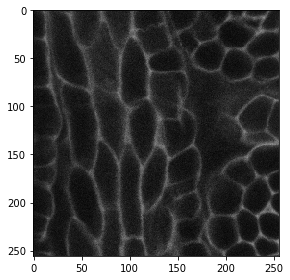

In [12]:
image = imread('https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/data/EM_C_6_c0.tif?raw=true', plugin='tifffile')

depth, height, width = image.shape
imshow(image[127])

For a more complex graphical user interface (GUI) processing 3D data, we define a couple of sliders:

In [13]:
z_slice_slider = widgets.IntSlider(
    value=depth / 2,
    min=0,
    max=depth,
    continuous_update=True,
    orientation='vertical',
)

background_subtraction_radius_slider = widgets.FloatSlider(
    value=4.5,
    min=0,
    max=20.0,
    step=0.1,
    description='Background subtraction:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

noise_removal_sigma_slider = widgets.FloatSlider(
    value=2.2,
    min=0,
    max=20.0,
    step=0.1,
    description='Noise removal:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

edge_dilation_radius_slider = widgets.FloatSlider(
    value=1.4,
    min=0,
    max=20,
    step=0.1,
    description='Edge dilation:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

threshold_slider = widgets.FloatSlider(
    value=10,
    min=0,
    max=50.0,
    step=0.1,
    description='Threshold:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

output_selector = widgets.RadioButtons(
    options=['background subtracted', 'denoised', 'edge eroded', 'binary', 'labels', 'result'],
    value='result',
    description='Show output:',
    disabled=False
)

Furthermore, we define two viewers for showing input and output images:

In [14]:
image_view = niw.NumpyImage(image[127])
result_view = niw.NumpyImage(image[127])

When executing longer workflows multiple times, it may make sense to allocate memory in advance. This spares re-allocation time in every execution.

In [15]:
# allocate memory
image_gpu = cle.push(image)
slice_gpu = cle.create([height, width])

# have global variables for reusing memory
background_subtracted_gpu = cle.create_like(image_gpu)
denoised_gpu = cle.create_like(image_gpu)
eroded_gpu = cle.create_like(image_gpu)
binary_gpu = cle.create_like(image_gpu)
labels_gpu = cle.create_labels_like(image_gpu)
result_gpu = cle.create_like(image_gpu)

We now attach events to the GUI. Those events will be executed when the user changes parameters.

In [16]:
def view_changed(event):
    
    cle.copy_slice(image_gpu, slice_gpu, slice_index=z_slice_slider.value)
    image_view.data = slice_gpu
    if output_selector.value == 'background subtracted':
        cle.copy_slice(background_subtracted_gpu, slice_gpu, slice_index=z_slice_slider.value)
    elif output_selector.value == 'denoised':
        cle.copy_slice(denoised_gpu, slice_gpu, slice_index=z_slice_slider.value)
    elif output_selector.value == 'edge eroded':
        cle.copy_slice(eroded_gpu, slice_gpu, slice_index=z_slice_slider.value)
    elif output_selector.value == 'binary':
        cle.copy_slice(binary_gpu, slice_gpu, slice_index=z_slice_slider.value)
    elif output_selector.value == 'labels':
        cle.copy_slice(labels_gpu, slice_gpu, slice_index=z_slice_slider.value)
    elif output_selector.value == 'result':
        cle.copy_slice(result_gpu, slice_gpu, slice_index=z_slice_slider.value)

    # in case min(result) == max(result), the viewer crashes
    if cle.maximum_of_all_pixels(slice_gpu) == cle.minimum_of_all_pixels(slice_gpu):
        cle.set_row(slice_gpu, 0, 1)
        cle.set_column(slice_gpu, 0, 0)
        
    result_view.data = slice_gpu

def parameters_changed(event):
    process_image(threshold_slider.value, 
                  background_subtraction_radius_slider.value, 
                  noise_removal_sigma_slider.value,
                  edge_dilation_radius_slider.value
                 )    
    view_changed(event)

# connect GUI elements with event handlers
threshold_slider.observe(parameters_changed)
background_subtraction_radius_slider.observe(parameters_changed)
edge_dilation_radius_slider.observe(parameters_changed)
noise_removal_sigma_slider.observe(parameters_changed)

z_slice_slider.observe(view_changed)
output_selector.observe(view_changed)

Finally, we define the image processing workflow in a function:

In [17]:
def process_image(threshold, background_subtraction_radius, noise_removal_sigma, edge_dilation_radius):
    # background removal
    cle.top_hat_box(image_gpu, background_subtracted_gpu, radius_x=background_subtraction_radius, radius_y=background_subtraction_radius, radius_z=background_subtraction_radius)
    
    # denoising
    cle.gaussian_blur(background_subtracted_gpu, denoised_gpu, sigma_x=noise_removal_sigma, sigma_y=noise_removal_sigma, sigma_z=noise_removal_sigma)
    
    # making membranes thicker in order to brige gaps
    cle.maximum_box(denoised_gpu, eroded_gpu, radius_x=edge_dilation_radius, radius_y=edge_dilation_radius, radius_z=edge_dilation_radius)
    
    # threshold the image
    cle.smaller_constant(eroded_gpu, binary_gpu, threshold)
    
    # label regions and fill black areas between regions
    cle.voronoi_labeling(binary_gpu, labels_gpu)
    
    # output the borders between the labels
    cle.detect_label_edges(labels_gpu, result_gpu)

# call it once to initialize the view
parameters_changed(None)

We now use horizontal and vertical box arrangements to view the GUI elements.

In [18]:
widgets.HBox([z_slice_slider, image_view, result_view,
             widgets.VBox([
                 background_subtraction_radius_slider,
                 noise_removal_sigma_slider,
                 edge_dilation_radius_slider,
                 threshold_slider,
                 output_selector
             ])])

Hint: After fine-tuning parameters, print them out!

In [19]:
background_subtraction_radius_slider.value

4.5

In [20]:
noise_removal_sigma_slider.value

2.2

In [21]:
edge_dilation_radius_slider.value

1.4

In [22]:
threshold_slider.value

10.0